# Cryptocurrency price forecasting

## Python packages

In [1]:
from pmdarima import auto_arima
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import joblib

In [1]:
import numpy 
print(numpy.__version__)

1.26.4


In [1]:
from pmdarima import auto_arima
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from prophet import Prophet
import joblib
from tensorflow.keras.models import load_model

c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
from tensorflow.keras.models import load_model

In [29]:
import joblib

## Import databases

In [2]:
# Fetch cryptocurrency data (e.g., Bitcoin)
btc_data = yf.download('BTC-USD', start='2019-01-01', end='2025-01-01')
print(btc_data.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD     BTC-USD
Date                                                                      
2019-01-01  3843.520020  3850.913818  3707.231201  3746.713379  4324200990
2019-01-02  3943.409424  3947.981201  3817.409424  3849.216309  5244856836
2019-01-03  3836.741211  3935.685059  3826.222900  3931.048584  4530215219
2019-01-04  3857.717529  3865.934570  3783.853760  3832.040039  4847965467
2019-01-05  3845.194580  3904.903076  3836.900146  3851.973877  5137609824


In [3]:
# Assume you have another dataset, such as S&P 500
sp500_data = yf.download('^GSPC', start='2019-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed


## Data Processing

In [4]:
# get only level 0 columns
btc_data.columns = btc_data.columns.levels[0]
sp500_data.columns = sp500_data.columns.levels[0]

In [5]:
btc_data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-01,3843.520020,3850.913818,3707.231201,3746.713379,4324200990
2019-01-02,3943.409424,3947.981201,3817.409424,3849.216309,5244856836
2019-01-03,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
2019-01-04,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
2019-01-05,3845.194580,3904.903076,3836.900146,3851.973877,5137609824


In [6]:
btc_data.describe()

Price,Close,High,Low,Open,Volume
count,2192.000000,2192.000000,2192.000000,2192.000000,2.192000e+03
mean,31501.407139,32155.585661,30745.767470,31462.483957,3.043984e+10
std,22114.308430,22576.554349,21579.657797,22085.026506,1.908530e+10
min,3399.471680,3427.945557,3391.023682,3401.376465,4.324201e+09
25%,10581.344727,10776.521973,10311.956543,10577.423828,1.788499e+10
50%,27334.937500,27820.822266,26865.267578,27301.943359,2.673177e+10
75%,46454.189453,47511.051758,45238.041016,46423.242188,3.775100e+10
max,106140.601562,108268.445312,105291.734375,106147.296875,3.509679e+11


In [7]:
# Count missing values in each column
print(btc_data.isnull().sum()) 

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

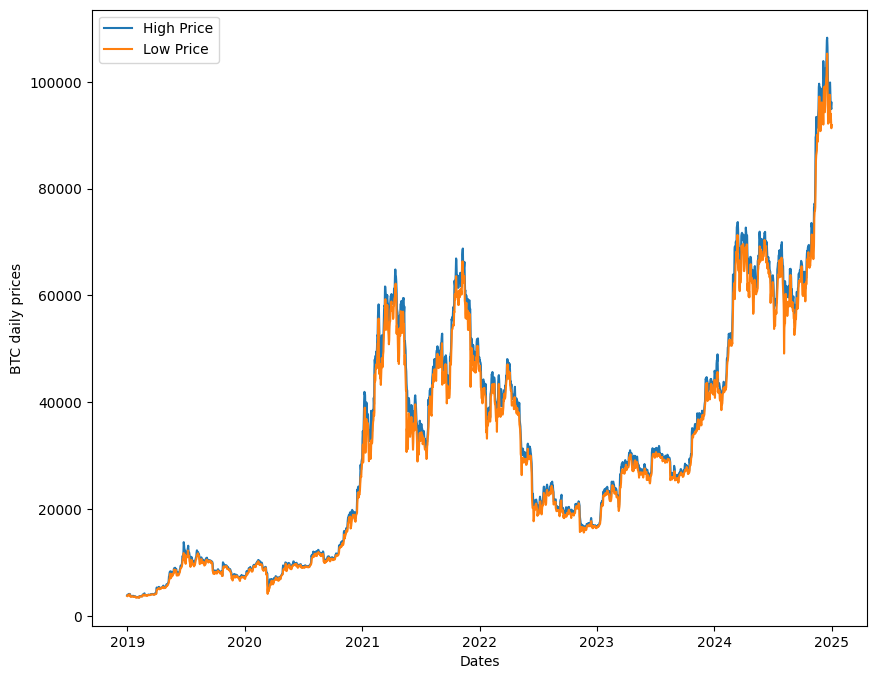

In [8]:
# print BTC highest and closing price 
plt.figure(figsize=(10,8))
plt.plot(btc_data["High"], label='High Price')
plt.plot(btc_data["Low"], label='Low Price')
plt.xlabel("Dates")
plt.ylabel("BTC daily prices")
plt.legend()
plt.show



In [9]:
# compute simple moving average (SMA) for 50 and 200 days to get a sense of the long & short term BTC trends. 
btc_data['SMA50'] = btc_data['Close'].rolling(window=50).mean()
btc_data['SMA200'] = btc_data['Close'].rolling(window=200).mean()

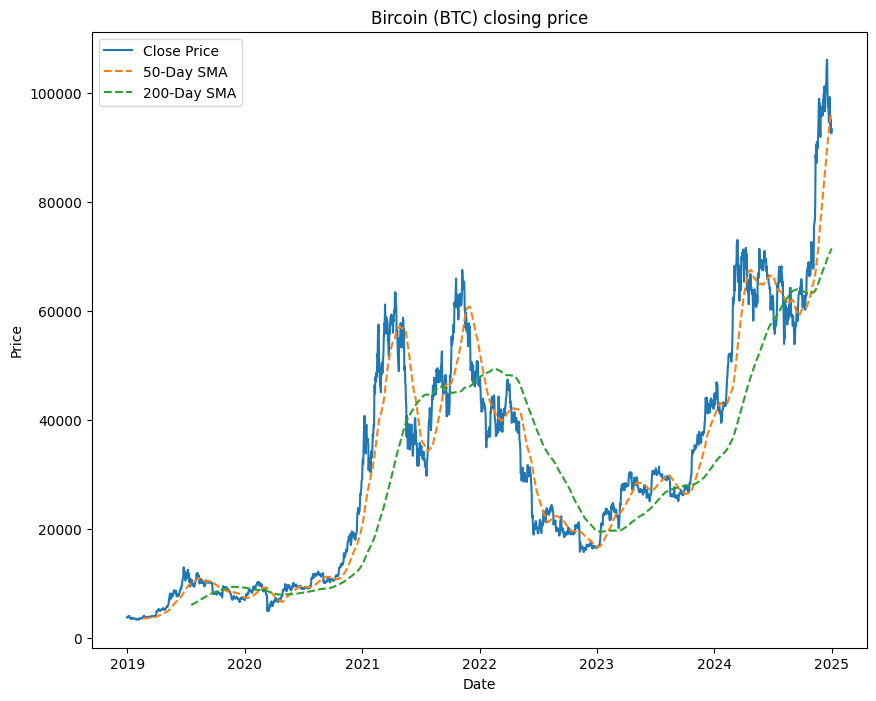

In [10]:
plt.figure(figsize=((10,8)))
plt.plot(btc_data["Close"], label='Close Price')
plt.plot(btc_data["SMA50"], label='50-Day SMA', linestyle='--')
plt.plot(btc_data["SMA200"], label='200-Day SMA', linestyle='--')
plt.title("Bircoin (BTC) closing price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### Check the stationarity of BTC price using ADF test

### Add S&P 500 stock market index

In [11]:
sp500_data.head(10)

Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,2510.030029,2519.489990,2467.469971,2476.959961,3733160000
2019-01-03,2447.889893,2493.139893,2443.959961,2491.919922,3858830000
2019-01-04,2531.939941,2538.070068,2474.330078,2474.330078,4234140000
2019-01-07,2549.689941,2566.159912,2524.560059,2535.610107,4133120000
2019-01-08,2574.409912,2579.820068,2547.560059,2568.110107,4120060000
2019-01-09,2584.959961,2595.320068,2568.889893,2580.000000,4088740000
2019-01-10,2596.639893,2597.820068,2562.020020,2573.510010,3721300000
2019-01-11,2596.260010,2596.270020,2577.399902,2588.110107,3447460000
2019-01-14,2582.610107,2589.320068,2570.409912,2580.310059,3689370000


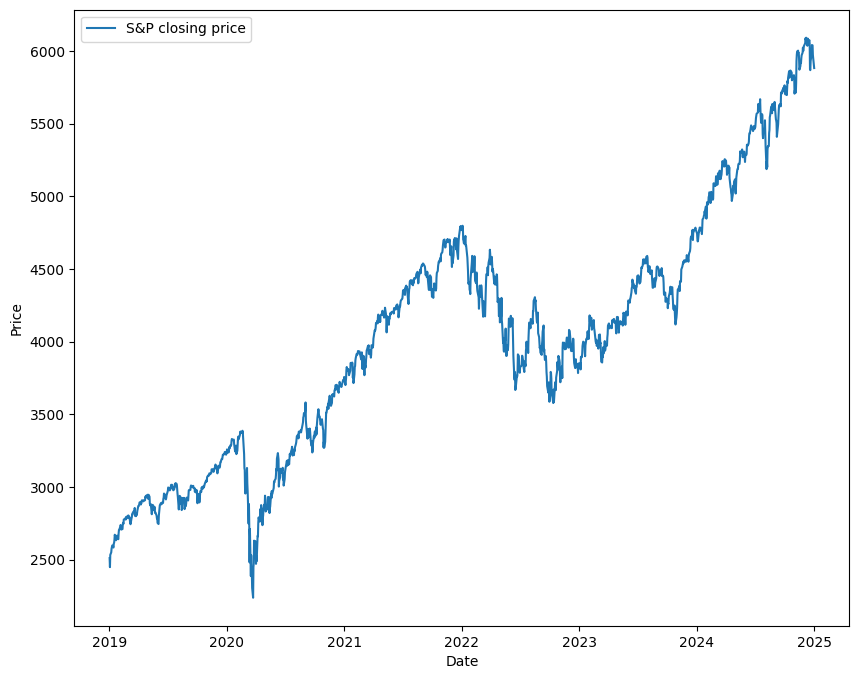

In [12]:
plt.figure(figsize=(10,8))
#plt.plot(merged_data["Close_BTC"], label = "BTC closing price")
plt.plot(sp500_data["Close"], label = "S&P closing price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [13]:
# merge sp500_data with btc_data
merged_data  = pd.merge(btc_data, sp500_data, left_index = True, right_index = True, suffixes=('_BTC', '_S&P500'))

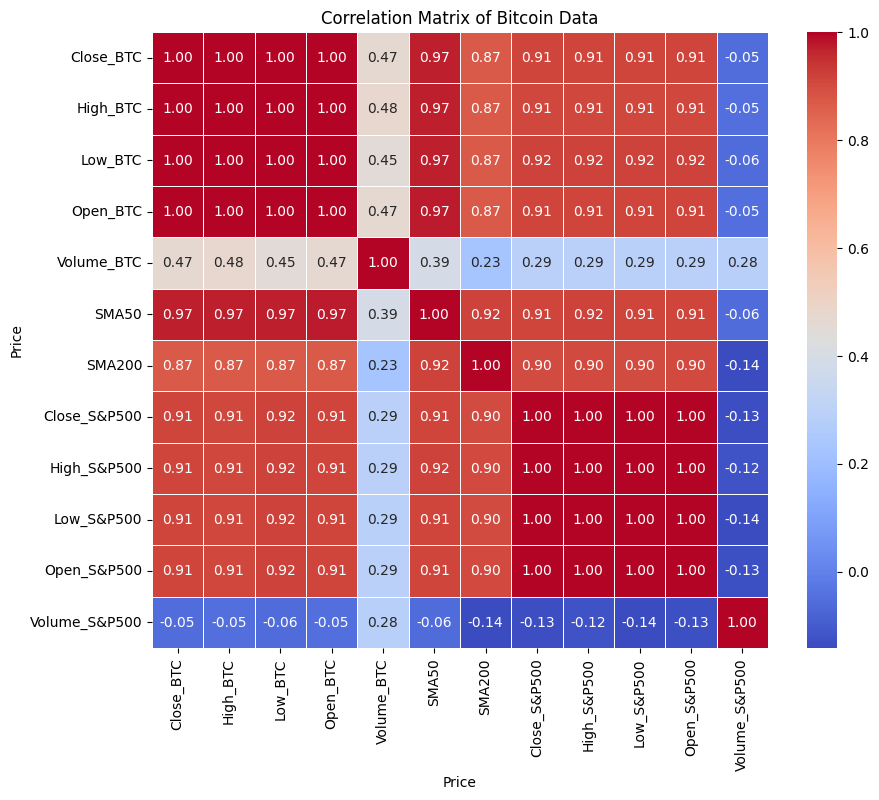

In [14]:
# compute correlation matrix
matrix_corr = merged_data.corr()

# plot correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
# Display the plot
plt.title("Correlation Matrix of Bitcoin Data")
plt.show()

Based on the correlation matrix, the BTC and S&P 500 closing prices are correlated. Suggesting that we should include both in the prediction model.

In [15]:
# for prediction, we will only keep BTC and S&P 500 closing prices
merged_data = merged_data[["Close_BTC", "Close_S&P500"]]

In [62]:
merged_data

Price,Close_BTC,Close_S&P500
Date,,
2019-01-02,3943.409424,2510.030029
2019-01-03,3836.741211,2447.889893
2019-01-04,3857.717529,2531.939941
2019-01-07,4025.248291,2549.689941
2019-01-08,4030.847900,2574.409912
...,...,...
2024-12-24,98676.093750,6040.040039
2024-12-26,95795.515625,6037.589844
2024-12-27,94164.859375,5970.839844


### Split the Data into Training and Test Sets

In [74]:
date = "Date"
target = "Close_BTC"

In [64]:
    # reset index of train data
    merged_data.reset_index(inplace = True)

    # rename merged_data's columns
    merged_data.rename(columns={date:'ds', target:'y'}, inplace = True)

In [155]:
# Split data into train and test sets (80% train, 20% test)
# train_size = int(len(merged_data) * 0.8)
train_size = int(len(merged_data) * 0.5)

data_train, data_test = merged_data[:train_size], merged_data[train_size:]

In [156]:
# index of data test
data_test_index = data_test.index

In [153]:
def arima_model(data_train, data_test, target, retrain=False):


    if retrain:
        # Fit the model with auto_arima
        model = auto_arima(data_train[[target]], 
                        seasonal=False,  # Set to True if your data has a seasonal component
                        m=1,             # Seasonality period, 1 means no seasonality
                        stepwise=True,   # Uses stepwise search for optimal parameters
                        trace=True)      # Print the search process

        # Save the model
        joblib.dump(model, 'models/arima_model.pkl')
        # Access the best parameters
        # best_p = model.order[0]
        # best_d = model.order[1]
        # best_q = model.order[2]

    # Load the saved model
    loaded_model = joblib.load('models/arima_model.pkl')

    # Forecast the next 10 time points (adjust number of steps as needed)
    forecast_steps = len(data_test)
    forecasted_values = loaded_model.predict(n_periods=forecast_steps)

    # set test index to forcasted data

    # set test index to forcasted data
    # forecasted_values.index = data_test.index
    forecasted_values = pd.DataFrame(forecasted_values, columns = ['yhat'])
    forecasted_values['ds'] = data_test['ds']

    # print("columns : -- ", forecasted_values.columns)


    # # Plot the forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
    plt.plot(data_test['ds'], data_test['y'], label='Test Data', color='green')
    plt.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast')
    plt.show()

    return data_train, data_test, forecasted_values
    


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.p

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12984.478, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13006.139, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13007.518, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13007.522, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13005.466, Time=0.02 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.p

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13004.592, Time=0.37 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13004.242, Time=0.42 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12984.756, Time=0.69 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12984.673, Time=0.73 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13005.649, Time=0.30 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13005.215, Time=0.53 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13005.471, Time=0.22 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.79 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=12983.611, Time=0.48 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13003.791, Time=0.24 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13003.294, Time=0.24 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=12983.732, Time=0.48 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=12983.609, Time=0.85 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=13004.304, Time=0.25 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=12987.416, Time=1.46 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=12985.332, Time=1.11 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=13002.399, Time=0.53 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=12982.058, Time=1.70 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=12982.084, Time=1.64 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0]             : AIC=12982.063, Time=2.05 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0]             : AIC=12986.656, Time=1.00 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=12983.255, Time=1.46 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0]             : AIC=12984.087, Time=1.96 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=12983.365, Time=2.11 sec

Best model:  ARIMA(3,1,4)(0,0,0)[0]          
Total fit time: 23.461 seconds


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


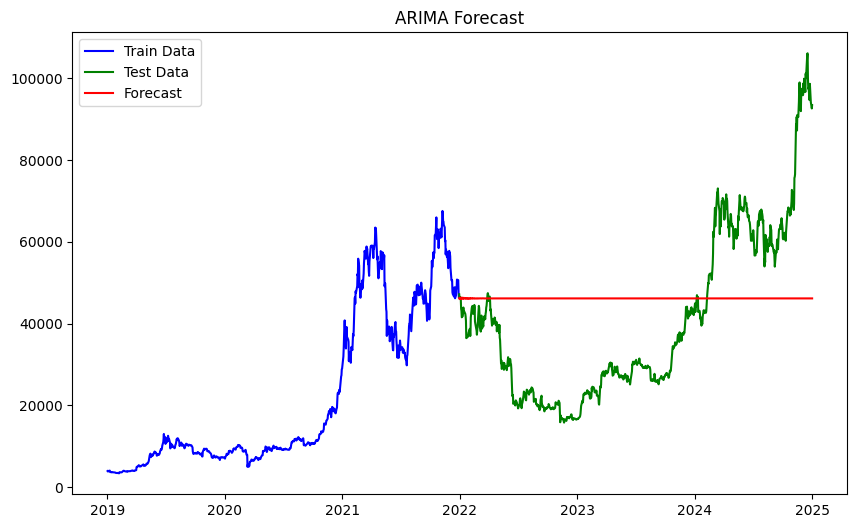

In [154]:
data_train, data_test, forecast_original_scale = arima_model(data_train, data_test, "y", "ds")

In [80]:
def arima_model(data_train, data_test, target, date, retrain=False):
    if retrain:
        # Fit the model with auto_arima
        model = auto_arima(data_train[[target]], 
                        seasonal=False,  # Set to True if your data has a seasonal component
                        m=1,             # Seasonality period, 1 means no seasonality
                        stepwise=True,   # Uses stepwise search for optimal parameters
                        trace=True)      # Print the search process

        # Save the model
        joblib.dump(model, 'models/arima_model.pkl')
        # Access the best parameters
        # best_p = model.order[0]
        # best_d = model.order[1]
        # best_q = model.order[2]

    # Load the saved model
    loaded_model = joblib.load('models/arima_model.pkl')

    # Forecast the next 10 time points (adjust number of steps as needed)
    forecast_steps = len(data_test)
    forecast = loaded_model.predict(n_periods=forecast_steps)

    # set test index to forcasted data
    forecasted_values.index = data_test[date]

    forecasted_values = pd.DataFrame(forecasted_values, columns = ["yhat"]).reset_index()

    # Plot the forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
    plt.plot(data_test['ds'], data_test['y'], label='Test Data', color='green')
    plt.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast')
    plt.show()

    return data_train, data_test, forecast_original_scale
    


In [ ]:
(data_train, data_test, date, target, retrain=False)

In [164]:
data_train

Price,ds,y,Close_S&P500
0,2019-01-02,3943.409424,2510.030029
1,2019-01-03,3836.741211,2447.889893
2,2019-01-04,3857.717529,2531.939941
3,2019-01-07,4025.248291,2549.689941
4,2019-01-08,4030.847900,2574.409912
...,...,...,...
750,2021-12-22,48628.511719,4696.560059
751,2021-12-23,50784.539062,4725.790039
752,2021-12-27,50640.417969,4791.189941
753,2021-12-28,47588.855469,4786.350098


In [168]:
data_train

Price,ds,y,Close_S&P500
0,2019-01-02,3943.409424,2510.030029
1,2019-01-03,3836.741211,2447.889893
2,2019-01-04,3857.717529,2531.939941
3,2019-01-07,4025.248291,2549.689941
4,2019-01-08,4030.847900,2574.409912
...,...,...,...
750,2021-12-22,48628.511719,4696.560059
751,2021-12-23,50784.539062,4725.790039
752,2021-12-27,50640.417969,4791.189941
753,2021-12-28,47588.855469,4786.350098


In [228]:
# Split data into train and test sets (80% train, 20% test)
# train_size = int(len(merged_data) * 0.8)
train_size = int(len(merged_data) * 0.5)

data_train, data_test = merged_data[:train_size], merged_data[train_size:]

In [231]:
data_test['ds'][-len(forecasted_values):]

761    2022-01-07
762    2022-01-10
763    2022-01-11
764    2022-01-12
765    2022-01-13
          ...    
1505   2024-12-24
1506   2024-12-26
1507   2024-12-27
1508   2024-12-30
1509   2024-12-31
Name: ds, Length: 749, dtype: datetime64[ns]

In [ ]:
data_test

In [254]:
def lstm_model(data_train, data_test, date, target, retrain=False):
    n_steps_ahead_value = 1

    # Function to create sequences using both Bitcoin and S&P 500 data
    def create_sequences_multivariate(data_in, time_step=6, n_steps_ahead=n_steps_ahead_value):
        """ 
        This function reshapes data_in to be 3D as expected by LSTM (samples, time steps, features)
        """
        X_out = []
        y_out = []
        for i in range(time_step, len(data_in)-n_steps_ahead + 1):
            X_out.append(data_in[i-time_step:i, :])  # Take the previous `time_step` data as input (both Bitcoin and S&P 500)
            y_out.append(data_in[i:i+n_steps_ahead, 0])  # Predict the next n_steps_ahead Bitcoin price
        return np.array(X_out), np.array(y_out)
    
    if retrain:
        # Initialize the MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Scale both Bitcoin and S&P 500 data (since we now have two features)
        data_train_norm = scaler.fit_transform(data_train[[target]])

        # Save the fitted scaler 
        joblib.dump(scaler, 'models/minmax_scaler.joblib')

    # Load the saved scaler
    scaler_loaded = joblib.load('models/minmax_scaler.joblib')

    # Scale both Bitcoin and S&P 500 data for test dataset
    data_train_norm = scaler_loaded.transform(data_train[[target]])

    # Scale both Bitcoin and S&P 500 data for test dataset
    data_test_norm = scaler_loaded.transform(data_test[[target]])

    # Create sequences with the train data (including both Bitcoin and S&P 500 features)
    X_train, y_train = create_sequences_multivariate(data_train_norm, n_steps_ahead=n_steps_ahead_value)

    # Create sequences with the test data (including both Bitcoin and S&P 500 features)
    X_test, y_test = create_sequences_multivariate(data_test_norm, n_steps_ahead=n_steps_ahead_value)

    if retrain:
        # Define the LSTM model
        model = Sequential()

        # Add LSTM layers
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(units=50, return_sequences=False))

        # Add Dropout to prevent overfitting
        model.add(Dropout(0.2))

        # Add a Dense output layer
        model.add(Dense(units=n_steps_ahead_value))  # Predict the next Bitcoin price

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

        # Save the entire model (architecture + weights)
        model.save('models/lstm_model.h5')  # Save the model to a file


    # Load the saved model
    loaded_model = load_model('models/lstm_model.h5')

    # Make predictions on the test data
    forecasted_values = loaded_model.predict(X_test)

    # Inverse transform the predictions and actual values to get the actual Bitcoin price scale
    forecasted_values = scaler_loaded.inverse_transform(np.concatenate((forecasted_values, np.zeros((forecasted_values.shape[0], 1))), axis=1))[:,0]
    y_test_actual = scaler_loaded.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:,0]


    forecasted_values = pd.DataFrame(forecasted_values, columns = ['yhat'])
    forecasted_values[date] = list(data_test.iloc[-len(forecasted_values):][date])

    data_test_edit = pd.DataFrame(y_test_actual, columns = ['y'])
    data_test_edit[date] = list(data_test.iloc[-len(forecasted_values):][date])

    # Plot the forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
    plt.plot(data_test_edit['ds'], data_test_edit['y'], label='Test Data', color='green')
    plt.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast')
    plt.show()



    return data_train, data_test_edit, forecasted_values

In [227]:
data_test['ds']

0     NaT
1     NaT
2     NaT
3     NaT
4     NaT
       ..
744   NaT
745   NaT
746   NaT
747   NaT
748   NaT
Name: ds, Length: 749, dtype: datetime64[ns]

In [215]:
data_train

Price,ds,y,Close_S&P500
0,2019-01-02,3943.409424,2510.030029
1,2019-01-03,3836.741211,2447.889893
2,2019-01-04,3857.717529,2531.939941
3,2019-01-07,4025.248291,2549.689941
4,2019-01-08,4030.847900,2574.409912
...,...,...,...
750,2021-12-22,48628.511719,4696.560059
751,2021-12-23,50784.539062,4725.790039
752,2021-12-27,50640.417969,4791.189941
753,2021-12-28,47588.855469,4786.350098


In [242]:
list(data_test.iloc[-len(forecasted_values):]['ds'])

[Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-01-11 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-18 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2022-01-20 00:00:00'),
 Timestamp('2022-01-21 00:00:00'),
 Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-28 00:00:00'),
 Timestamp('2022-01-31 00:00:00'),
 Timestamp('2022-02-01 00:00:00'),
 Timestamp('2022-02-02 00:00:00'),
 Timestamp('2022-02-03 00:00:00'),
 Timestamp('2022-02-04 00:00:00'),
 Timestamp('2022-02-07 00:00:00'),
 Timestamp('2022-02-08 00:00:00'),
 Timestamp('2022-02-09 00:00:00'),
 Timestamp('2022-02-10 00:00:00'),
 Timestamp('2022-02-11 00:00:00'),
 Timestamp('2022-02-14 00:00:00'),
 Timestamp('2022-02-15 00:00:00'),
 Timestamp('2022-02-16 00:00:00'),
 Timestamp('2022-02-

Epoch 1/20


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0744 - val_loss: 0.0066
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_l

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


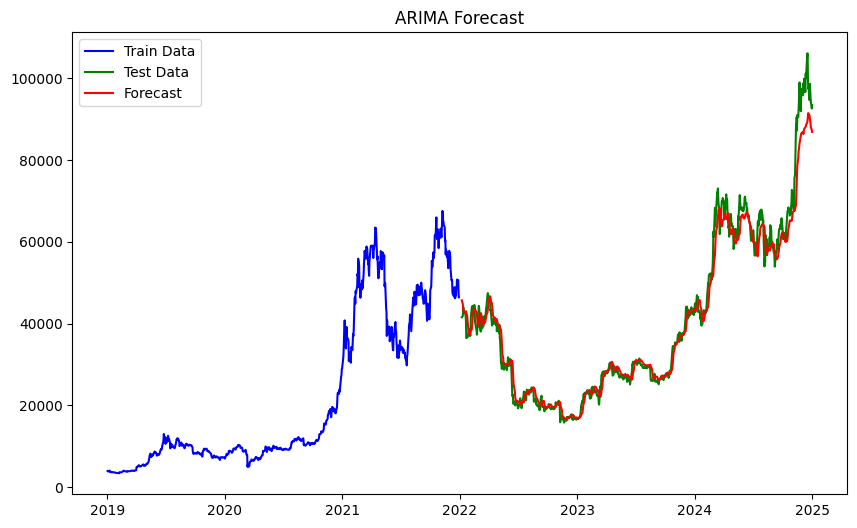

In [255]:
data_train, data_test, forecasted_values = lstm_model(data_train, data_test, 'ds', 'y', retrain=True)

In [193]:
def lstm_model(data_train, data_test, date, target, retrain=False):
    n_steps_ahead_value = 1

    # Function to create sequences using both Bitcoin and S&P 500 data
    def create_sequences_multivariate(data_in, time_step=6, n_steps_ahead=n_steps_ahead_value):
        """ 
        This function reshapes data_in to be 3D as expected by LSTM (samples, time steps, features)
        """
        X_out = []
        y_out = []
        for i in range(time_step, len(data_in)-n_steps_ahead + 1):
            X_out.append(data_in[i-time_step:i, :])  # Take the previous `time_step` data as input (both Bitcoin and S&P 500)
            y_out.append(data_in[i:i+n_steps_ahead, 0])  # Predict the next n_steps_ahead Bitcoin price
        return np.array(X_out), np.array(y_out)
    
    if retrain:
        # Initialize the MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Scale both Bitcoin and S&P 500 data (since we now have two features)
        data_train_norm = scaler.fit_transform(data_train[[target]])

        # Save the fitted scaler 
        joblib.dump(scaler, 'models/minmax_scaler.joblib')

    # Load the saved scaler
    scaler_loaded = joblib.load('models/minmax_scaler.joblib')

    # Scale both Bitcoin and S&P 500 data for test dataset
    data_train_norm = scaler_loaded.transform(data_train[[target]])

    # Scale both Bitcoin and S&P 500 data for test dataset
    data_test_norm = scaler_loaded.transform(data_test[[target]])

    # Create sequences with the train data (including both Bitcoin and S&P 500 features)
    X_train, y_train = create_sequences_multivariate(data_train_norm, n_steps_ahead=n_steps_ahead_value)

    # Create sequences with the test data (including both Bitcoin and S&P 500 features)
    X_test, y_test = create_sequences_multivariate(data_test_norm, n_steps_ahead=n_steps_ahead_value)

    if retrain:
        # Define the LSTM model
        model = Sequential()

        # Add LSTM layers
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(units=50, return_sequences=False))

        # Add Dropout to prevent overfitting
        model.add(Dropout(0.2))

        # Add a Dense output layer
        model.add(Dense(units=n_steps_ahead_value))  # Predict the next Bitcoin price

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

        # Save the entire model (architecture + weights)
        model.save('models/lstm_model.h5')  # Save the model to a file


    # Load the saved model
    loaded_model = load_model('models/lstm_model.h5')

    # Make predictions on the test data
    forecasted_values = loaded_model.predict(X_test)

    # Inverse transform the predictions and actual values to get the actual Bitcoin price scale
    forecasted_values = scaler_loaded.inverse_transform(np.concatenate((forecasted_values, np.zeros((forecasted_values.shape[0], 1))), axis=1))[:,0]
    y_test_actual = scaler_loaded.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:,0]


    # Plot the actual vs predicted prices
    plt.figure(figsize=(10,6))
    plt.plot(data_train[date], data_train[target], label='Train Data', color='blue')
    plt.plot(data_test[date][-len(forecasted_values):], y_test_actual, label='Actual Price')
    plt.plot(data_test[date][-len(forecasted_values):], forecasted_values, label='Predicted Price')
    # plt.plot(data_test_index[-len(predictions):], y_test_actual, label='Actual Price')
    # plt.plot(data_test_index[-len(predictions):], predictions, label='Predicted Price')
    plt.title("Bitcoin Price Prediction (Test Set) with S&P 500 Data")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()
    return data_train, data_test, forecasted_values


In [ ]:
forecasted_values

Epoch 1/20


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1087 - val_loss: 0.0061
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_l

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


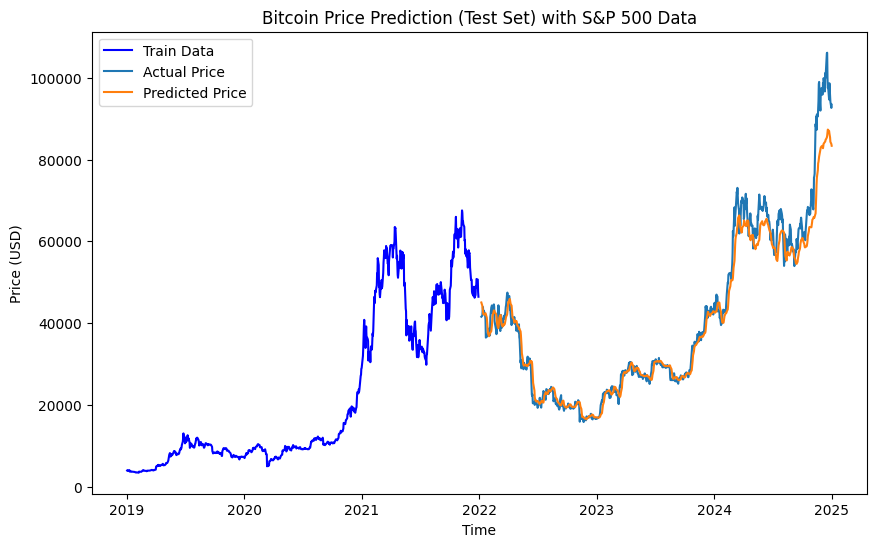

(Price         ds             y  Close_S&P500
 0     2019-01-02   3943.409424   2510.030029
 1     2019-01-03   3836.741211   2447.889893
 2     2019-01-04   3857.717529   2531.939941
 3     2019-01-07   4025.248291   2549.689941
 4     2019-01-08   4030.847900   2574.409912
 ..           ...           ...           ...
 750   2021-12-22  48628.511719   4696.560059
 751   2021-12-23  50784.539062   4725.790039
 752   2021-12-27  50640.417969   4791.189941
 753   2021-12-28  47588.855469   4786.350098
 754   2021-12-29  46444.710938   4793.060059
 
 [755 rows x 3 columns],
 Price         ds             y  Close_S&P500
 755   2021-12-30  47178.125000   4778.729980
 756   2021-12-31  46306.445312   4766.180176
 757   2022-01-03  46458.117188   4796.560059
 758   2022-01-04  45897.574219   4793.540039
 759   2022-01-05  43569.003906   4700.580078
 ...          ...           ...           ...
 1505  2024-12-24  98676.093750   6040.040039
 1506  2024-12-26  95795.515625   6037.589844
 1507  

In [190]:
lstm_model(data_train, data_test, 'ds', 'y', retrain=True)

In [44]:
data_train.columns

Index(['Close_BTC', 'Close_S&P500'], dtype='object', name='Price')

In [48]:
def prophet_model(data_train, data_test, date, target, retrain=False):
    # reset index of train data
    data_train.reset_index(inplace = True)

    # reset index of test data
    data_test.reset_index(inplace = True)

    # rename train's columns
    data_train.rename(columns={date:'ds', target:'y'}, inplace = True)

    # rename test's columns
    data_test.rename(columns={date:'ds', target:'y'}, inplace = True)

    if retrain:
        # Initialize the Prophet model
        prophet_model = Prophet()

        # Add the S&P500 data as an additional regressor to improve predictions
        #prophet_model.add_regressor('Close_S&P500')

        # Fit the model on the merged data
        prophet_model.fit(data_train)

        # Save the model with joblib
        joblib.dump(prophet_model, 'models/prophet_model.joblib')

    # Load the model with joblib
    loaded_model = joblib.load('models/prophet_model.joblib')

    # Predict future values
    #forecast = prophet_model.predict(data_test[['ds', 'Close_S&P500']])
    forecast = loaded_model.predict(data_test[['ds']])

    # Extract the forecasted values and dates
    forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    plt.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
    plt.plot(data_test['ds'], data_test['y'], label='Test Data', color='green')
    plt.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
    plt.fill_between(forecasted_values['ds'], forecasted_values['yhat_lower'], forecasted_values['yhat_upper'], 
                    color='red', alpha=0.2, label='Confidence Interval')

    plt.title('Prophet Forecasting with Train and Test Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

C:\Users\anass\AppData\Local\Temp\ipykernel_5672\3783986217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.rename(columns={date:'ds', target:'y'}, inplace = True)
C:\Users\anass\AppData\Local\Temp\ipykernel_5672\3783986217.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.rename(columns={date:'ds', target:'y'}, inplace = True)


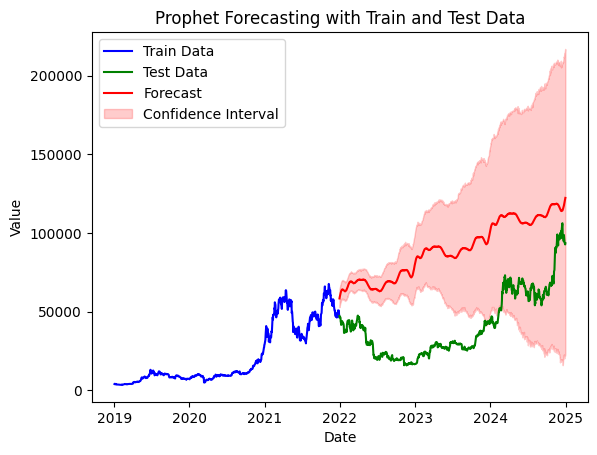

In [49]:
prophet_model(data_train, data_test, "Date", "Close_BTC")

In [ ]:
prophet_model(data_train, data_test)

## ARIMA and XARIMA model

ARIMA is an efficient model used for time series forcasting. It combines 3 components : 
#### 1- AutoRegressive (AR) part :
 It models the relationship between the current observation and the previous ones: It assumes that the current observation of the series is a linear function of its previous values. The number of lagged observations is represented by the parameter p (also called the order of the autoregressive part).


$$
y_t = \mu + \sum_{i=1}^{p} \phi_i y_{t-i} + \varepsilon_t
$$

Where:
- $ y_t $ is the value of the series at time t,
- $ \mu $ is the constant or mean of the time series,
- $ \phi_i $ are the coefficients of the AR part (autoregressive coefficients),
- $ y_{t-i} $ are the previous observations (lags) of the time series,
- $ \varepsilon_t $ is the error term at time t (white noise).

#### Differencing or Integration (I) part : 
This part of the ARIMA model aims at differencing the time series to make it stationary. A stationary time series have constant statistical properties, such as mean and variance over time. Many real-world time series have trends or seasonal patterns, making them non-stationary. The idea of this step is to remove the trends of the time series by substracting previous values from the current ones. This step could be repeated one or more times until the series become stationary. The order of differencing is noted as d which corresponds to the number of times the differencing was applied.


$$
\Delta y_t = y_t - y_{t-1}
$$

Where:
- $ \Delta y_t $ represents the first difference of the time series,
- $ y_t $ is the current observation at time t,
- $ y_{t-1} $ is the observation at time t-1.

#### Moving average (MA):
The MA part of ARIMA is used to model the error term as a linear combination of the previous errors. In other words, it looks at how the past forcasting errors influence the current value of the series. 
The general form of a moving average model of order q (MA(q)) is:

$$
y_t = \mu + \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
$$

Where:
- $ y_t $ is the observed value at time $ t $,
- $ \mu $ is a constant (mean),
- $ \varepsilon_t $ is the error term (residual) at time $ t $,
- $ \theta_i $ are the coefficients of the MA part (moving average coefficients),
- $ \varepsilon_{t-i} $ are the past errors (residuals).


### Full ARIMA(p, d, q) Model

Combining all three parts (AR, I, and MA), the **ARIMA(p, d, q)** model is represented as:

$$
\Delta^d y_t = \mu + \sum_{i=1}^{p} \phi_i \Delta^d y_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t
$$

Where:
- $ \Delta^d y_t $ is the differenced series (after differencing the time series \( d \) times),
- $ \mu $ is the constant (mean),
- $ \phi_i $ are the AR coefficients (AutoRegressive terms),
- $ \varepsilon_t $ is the error term (white noise),
- $ \theta_j $ are the coefficients of the MA part (Moving Average terms),
- $ p $ is the number of autoregressive terms (lags),
- $ q $ is the number of moving average terms (lags),
- $ d $ is the degree of differencing applied to make the series stationary.

##### Check the stationarity of the model 

Before applying the ARIMA model, we need to check whether the price is stationary or not. For that, we are going to use 2 approaches. The first one is to plot the prices over time and the second approach is to use ADF (Augmented Dickey-Fuller) test.
To use the ADF test, we need to set up the null hypothesis (H0) in which we assume that the data is not stationary. If the p-value is less than 0.05, the (H0) is rejected, meaning the series is stationary.



<function matplotlib.pyplot.show(close=None, block=None)>

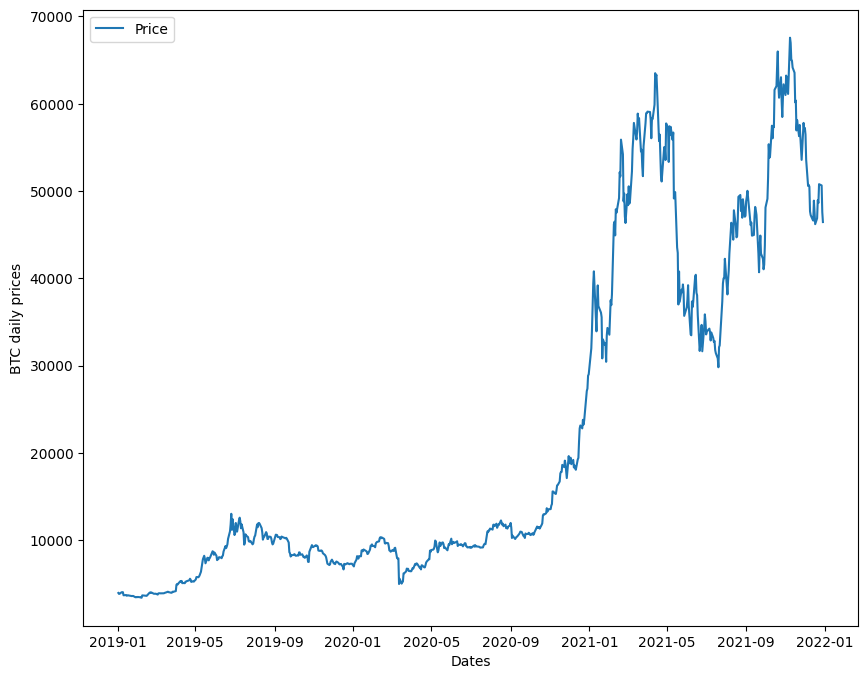

In [20]:
# print BTC prices
plt.figure(figsize=(10,8))
plt.plot(data_train["Close_BTC"], label='Price')
plt.xlabel("Dates")
plt.ylabel("BTC daily prices")
plt.legend()
plt.show

In [21]:
# Perform ADF test to check for stationarity
result = adfuller(data_train['Close_BTC'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Consider differencing.")

ADF Statistic: -0.8132161119129775
p-value: 0.8152090759828956
The series is non-stationary. Consider differencing.


From both approaches, we figure out that the data is not stationary. We need to use differencing approach which consists in substracting the previous values from the current ones.  

In [22]:
data_diff_train = data_train.diff().dropna()  # First differencing

data_diff_train = data_diff_train.diff().dropna()  # First differencing

#data_diff_train = data_diff_train.diff().dropna()  # First differencing

#data_diff_train = data_diff_train.diff().dropna()  # First differencing

Let's again check the stationarity of the model 

<function matplotlib.pyplot.show(close=None, block=None)>

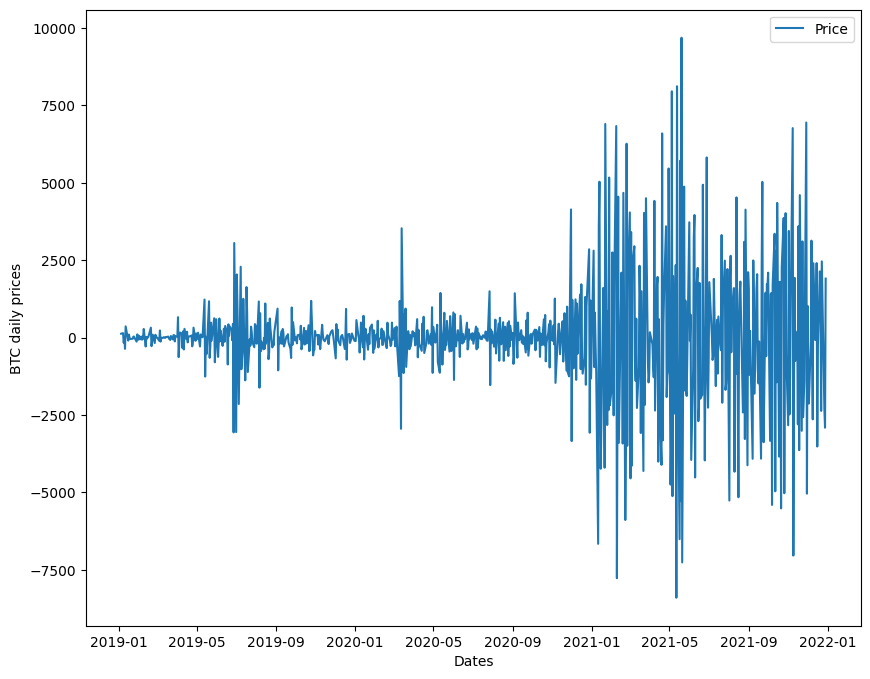

In [23]:
# print BTC prices 
plt.figure(figsize=(10,8))
plt.plot(data_diff_train["Close_BTC"], label='Price')
plt.xlabel("Dates")
plt.ylabel("BTC daily prices")
plt.legend()
plt.show

In [24]:
# Perform ADF test to check for stationarity
result = adfuller(data_diff_train['Close_BTC'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Consider differencing.")

ADF Statistic: -11.24528306215548
p-value: 1.7658844539838622e-20
The series is stationary.


Great, our series is stationary. The order of differencing is d = 1. 

Once our series is stationary, we are going to define the order of the AutoRegressive (AR) part (p) which represents how much the past values are influencing the current value. To find the optimal value of p, we are going to use ACF (AutoCorrelation fucntion) and PACF (Partial autoCorrelation function)

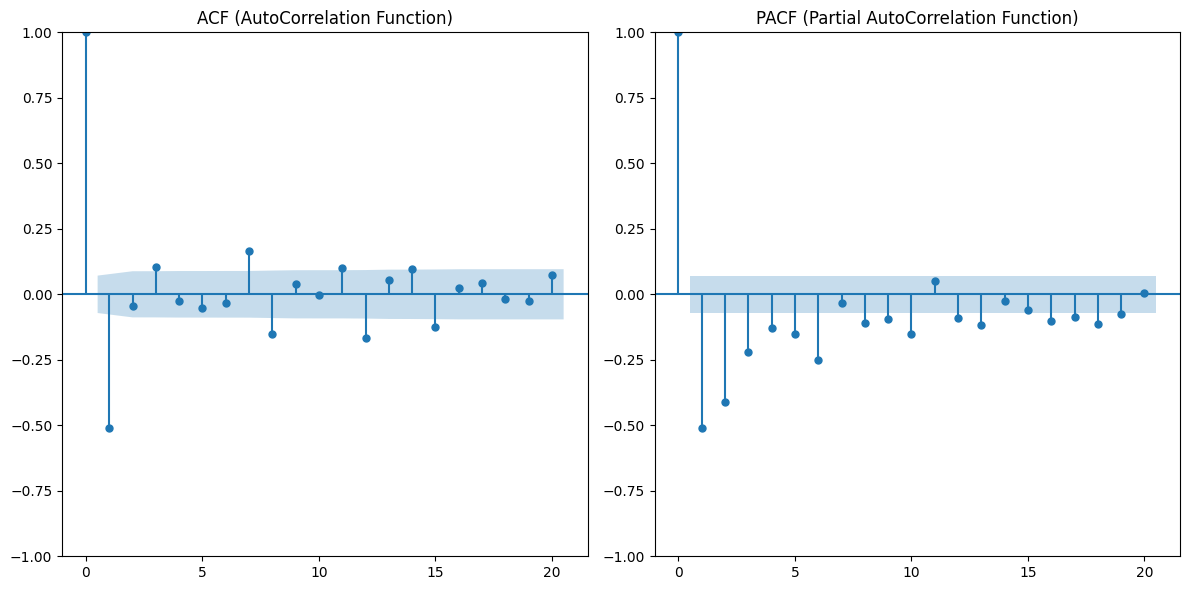

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data_diff_train['Close_BTC'], lags=20, ax=plt.gca())
plt.title('ACF (AutoCorrelation Function)')

plt.subplot(122)
plot_pacf(data_diff_train['Close_BTC'], lags=20, ax=plt.gca())
plt.title('PACF (Partial AutoCorrelation Function)')
plt.tight_layout()
plt.show()

- ACF plot is used to determine the q parameter (MA component). It shows the correlaction between the current value of the time series and residual (errors) from the past q observations.
- PACF plot is used to determine the p parameter (AR component). It suggests that only p previous values influence the current value.  

Based on the ACF and PACF plots, we find that the autocorrelation function cuts off after lag 1 so p=1 and the partial autocorrelation function cuts off after lag =1 so q = 1. This means that there is a strong correlation between $Y_{t}$ and $Y_{i-1}$. This suggests that the current value in the time series is only significantly influenced by the immediate previous value and not by values further in the past. 

- Get p, q and d automatically

For that we are going to use pmdarima library

In [26]:

# Fit the model with auto_arima
model = auto_arima(data_diff_train[["Close_BTC"]], 
                   seasonal=False,  # Set to True if your data has a seasonal component
                   m=1,             # Seasonality period, 1 means no seasonality
                   stepwise=True,   # Uses stepwise search for optimal parameters
                   trace=True)      # Print the search process

# Print the model summary
print(model.summary())

c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.p

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13530.576, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13305.022, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13167.732, Time=0.05 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.p

 ARIMA(3,0,0)(0,0,0)[0]             : AIC=13131.964, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=13121.171, Time=0.16 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0]             : AIC=13105.586, Time=0.09 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.04 sec


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=13107.581, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 3.346 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  753
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -6546.793
Date:                Mon, 27 Jan 2025   AIC                          13105.586
Time:                        10:14:04   BIC                          13133.330
Sample:                             0   HQIC                         13116.275
                                - 753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1- Fit the ARIMA Model

In [27]:
(p, d, q) = (3, 1, 4)
# Fit the ARIMA model with the identified p, d, q values
model = ARIMA(data_diff_train[["Close_BTC"]], order=(p, d, q))
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

                               SARIMAX Results                                
Dep. Variable:              Close_BTC   No. Observations:                  753
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -6500.190
Date:                Mon, 27 Jan 2025   AIC                          13016.381
Time:                        10:14:06   BIC                          13053.363
Sample:                             0   HQIC                         13030.629
                                - 753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0052      0.038    -52.398      0.000      -2.080      -1.930
ar.L2         -1.1027      0.071    -15.439      0.000      -1.243      -0.963
ar.L3         -0.0940      0.036     -2.584      0.0

c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2- Model Diagnostics (Check Residuals)

Once we fitted the model, it's important to check the residuals of the models (errors of the model). They should ideally resemble white noise (they should have no pattern or autocorrelation). If they are still correlated, this suggests that the models has not fully captured the underlying patterns in the data

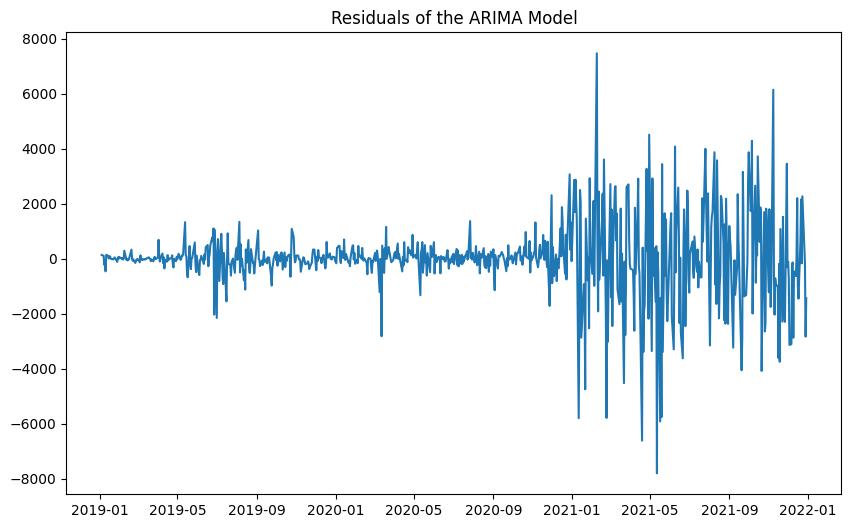

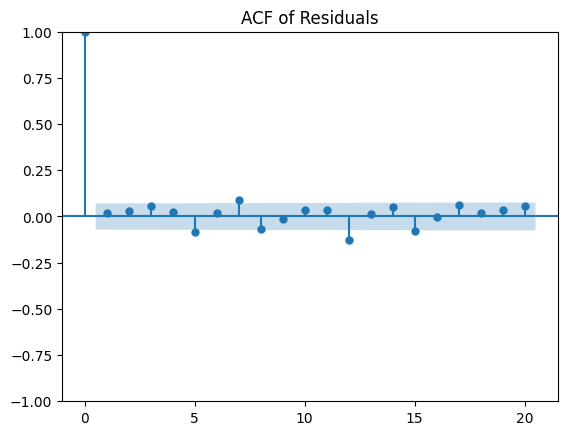

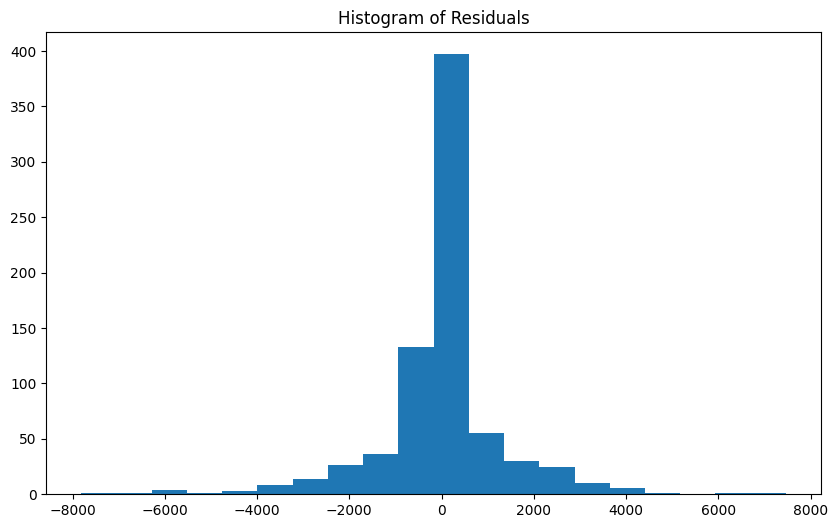

In [28]:
# Get residuals from the model
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.show()

# Plot the ACF of residuals to check for autocorrelation
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.show()

3- Forecasting

c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecasted values (original scale): 753     2980.772356
754     2032.317526
755     1680.763716
756     2122.828265
757     1713.190192
           ...     
1503    1907.300263
1504    1907.300263
1505    1907.300263
1506    1907.300263
1507    1907.300263
Name: predicted_mean, Length: 755, dtype: float64


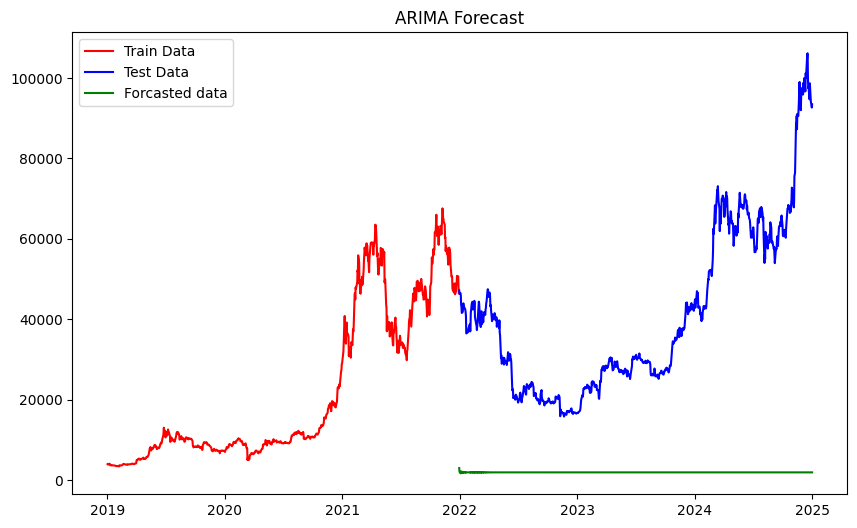

In [29]:
# Forecast the next 10 time points (adjust number of steps as needed)
forecast_steps = len(data_test)
forecast = model_fit.forecast(steps=forecast_steps)

# Assuming the last value of your original data is 'last_value'
last_value = data_diff_train["Close_BTC"].iloc[-1]

# Inverse Differencing: Add the forecasted values to the last observed value to get the values in the original scale 
forecast_original_scale = forecast + last_value
print("Forecasted values (original scale):", forecast_original_scale)

# set test index to forcasted data
forecast_original_scale.index = data_test.index

# Print the forecasted values
#print("Forecasted values:", forecast)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data_train["Close_BTC"], label='Train Data', color='red')  # Plot the train data
plt.plot(data_test["Close_BTC"], label='Test Data', color='blue')  # Plot the test data
plt.plot(forecast_original_scale, label='Forcasted data', color='green')  # Plot the predicted data
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

5- Model evaluation

In [30]:
# Calculate MSE and RMSE
mse = mean_squared_error(data_test["Close_BTC"], forecast_original_scale)
rmse = math.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(data_test["Close_BTC"], forecast_original_scale)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1960535419.2858589
Root Mean Squared Error: 44277.93377389983
Mean Absolute Error: 39160.65365701232


## SLTM model

Epoch 1/20


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0651 - val_loss: 0.0228
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0102 - val_loss: 0.0035
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_l

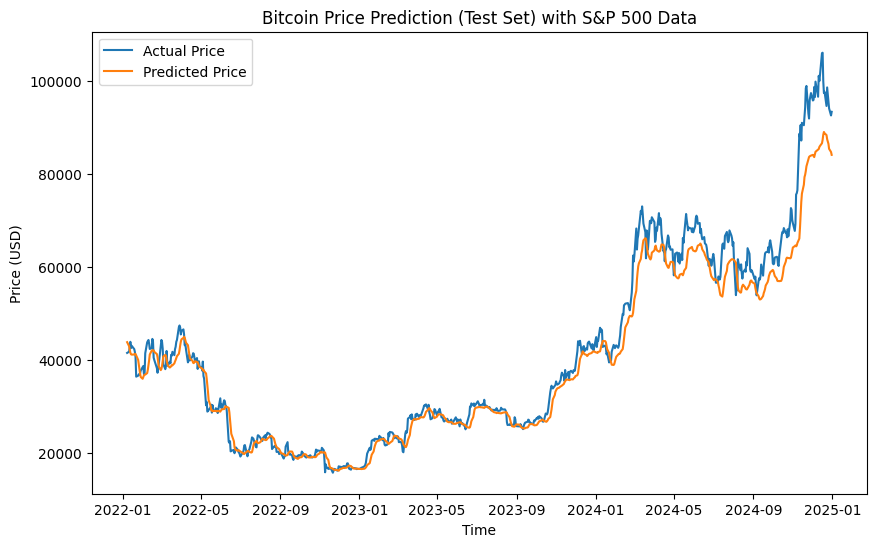

### Normalize the Data

In [32]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale both Bitcoin and S&P 500 data (since we now have two features)
data_train_norm = scaler.fit_transform(data_train)

# Scale both Bitcoin and S&P 500 data (since we now have two features)
data_test_norm = scaler.transform(data_test)

# Check the scaled data
data_test_norm[:5]

array([[0.68225739, 0.99439281],
       [0.66867292, 0.98948222],
       [0.67103661, 1.00136951],
       [0.66230097, 1.00018781],
       [0.62601195, 0.96381366]])

### Create Sequences with Both Bitcoin and S&P 500 Data

Now that we have both features (Bitcoin and S&P 500) closing prices, we’ll create input sequences for LSTM, using both features as the input variables.

In [33]:
n_steps_ahead_value = 1
# Function to create sequences using both Bitcoin and S&P 500 data
def create_sequences_multivariate(data_in, time_step=6, n_steps_ahead=n_steps_ahead_value):
    """ 
    This function reshapes data_in to be 3D as expected by LSTM (samples, time steps, features)
    """
    X_out = []
    y_out = []
    for i in range(time_step, len(data_in)-n_steps_ahead + 1):
        X_out.append(data_in[i-time_step:i, :])  # Take the previous `time_step` data as input (both Bitcoin and S&P 500)
        y_out.append(data_in[i:i+n_steps_ahead, 0])  # Predict the next n_steps_ahead Bitcoin price
    return np.array(X_out), np.array(y_out)



In [34]:
data_train

Price,Close_BTC,Close_S&P500
Date,,
2019-01-02,3943.409424,2510.030029
2019-01-03,3836.741211,2447.889893
2019-01-04,3857.717529,2531.939941
2019-01-07,4025.248291,2549.689941
2019-01-08,4030.847900,2574.409912
...,...,...
2021-12-22,48628.511719,4696.560059
2021-12-23,50784.539062,4725.790039
2021-12-27,50640.417969,4791.189941


In [35]:
# Create sequences with the train data (including both Bitcoin and S&P 500 features)
X_train, y_train = create_sequences_multivariate(data_train_norm, n_steps_ahead=n_steps_ahead_value)

# Create sequences with the test data (including both Bitcoin and S&P 500 features)
X_test, y_test = create_sequences_multivariate(data_test_norm, n_steps_ahead=n_steps_ahead_value)


# Check the shape of the input data
print("Train's shapes : ", X_train.shape, y_train.shape)

# Check the shape of the input data
print("Test's shapes : ", X_test.shape, y_test.shape)


Train's shapes :  (749, 6, 2) (749, 1)
Test's shapes :  (749, 6, 2) (749, 1)


### Define the LSTM model

Now, we will define the LSTM model, which will take as inputs S&P500 and BTC closing prices.

In [36]:
# Define the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))

# Add Dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a Dense output layer
model.add(Dense(units=n_steps_ahead_value))  # Predict the next Bitcoin price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()


c:\Users\anass\Documents\github\real-time-crypto-forcasting-with-arima-prophet-llm-news-sentiment\cryptovenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 6, 50)          │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

Now, can train our LSTM model with both BTC and S&P500 closing pice

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1271 - val_loss: 0.0194
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - val_loss: 0.0068
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 - val_loss: 0.0128
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

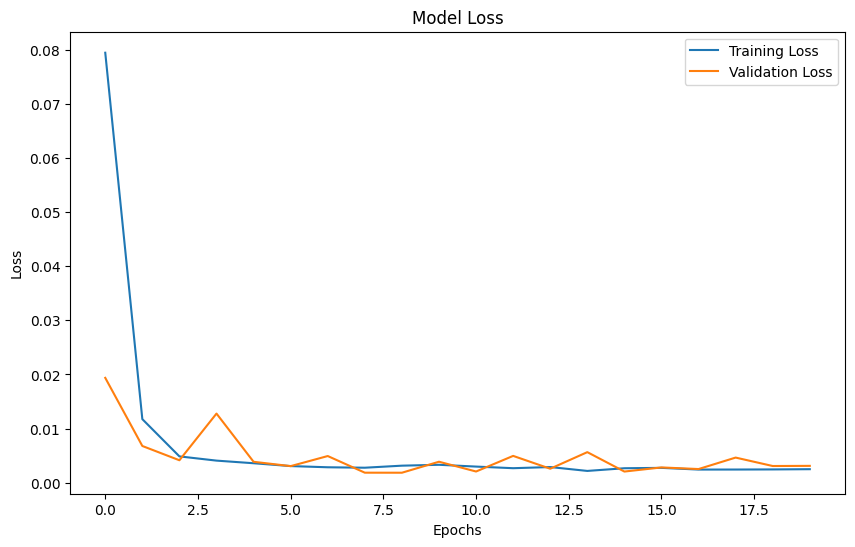

In [37]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make Predictions

In [38]:
# Make predictions on the test data
predictions = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


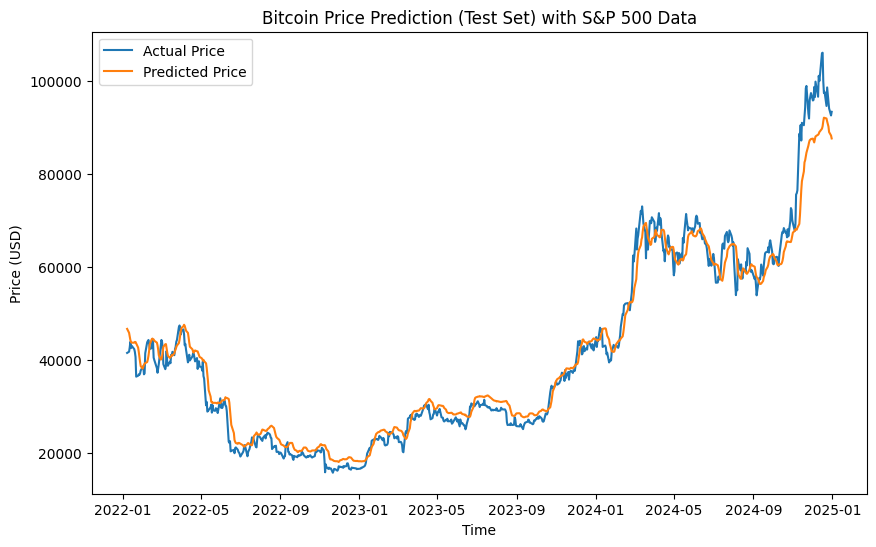

In [39]:
# Inverse transform the predictions and actual values to get the actual Bitcoin price scale
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:,0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:,0]

# Plot the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(data_test_index[-len(predictions):], y_test_actual, label='Actual Price')
plt.plot(data_test_index[-len(predictions):], predictions, label='Predicted Price')
plt.title("Bitcoin Price Prediction (Test Set) with S&P 500 Data")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### Evaluate the Model

For model evaluation, we are going to use mean squared error, root mean squared error and mean absolute error

In [40]:
# Calculate MSE and RMSE
mse = mean_squared_error(y_test_actual, predictions)
rmse = math.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 12791004.57302649
Root Mean Squared Error: 3576.451393913594
Mean Absolute Error: 2531.2179912521483


## Prophet model

C:\Users\anass\AppData\Local\Temp\ipykernel_9824\486776771.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)
C:\Users\anass\AppData\Local\Temp\ipykernel_9824\486776771.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)
10:20:40 - cmdstanpy - INFO - Chain [1] start processing
10:20:40 - cmdstanpy - INFO - Chain [1] done processing


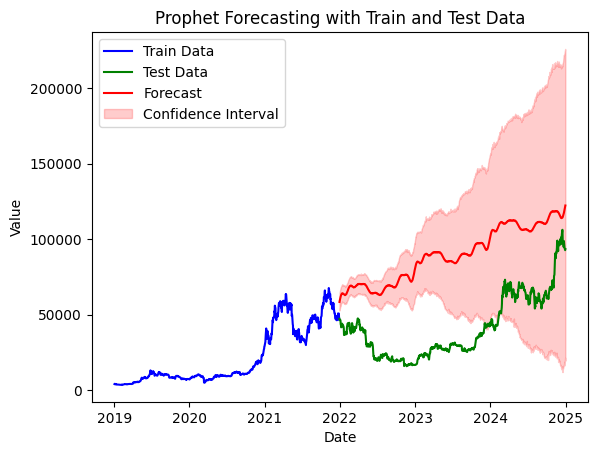

In [43]:
# reset index of train data
data_train.reset_index(inplace = True)

# reset index of test data
data_test.reset_index(inplace = True)

In [44]:
# rename train's columns
data_train.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)

# rename test's columns
data_test.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)

C:\Users\anass\AppData\Local\Temp\ipykernel_9824\3644670627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)
C:\Users\anass\AppData\Local\Temp\ipykernel_9824\3644670627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.rename(columns={'Date':'ds', 'Close_BTC':'y'}, inplace = True)


In [48]:
# Initialize the Prophet model
prophet_model = Prophet()

# Add the S&P500 data as an additional regressor to improve predictions
prophet_model.add_regressor('Close_S&P500')

# Fit the model on the merged data
prophet_model.fit(data_train)

# Step 4: Make future predictions
# Create a DataFrame with future dates for prediction
#future_dates = prophet_model.make_future_dataframe(data_train, periods=len(data_test))  # Predict for 365 days ahead


10:17:38 - cmdstanpy - INFO - Chain [1] start processing
10:17:40 - cmdstanpy - INFO - Chain [1] done processing


- save Prophet model

In [49]:
# Save the trained model to a file using joblib
#joblib.dump(prophet_model, 'prophet_model.joblib')

print("Model saved successfully!")

Model saved successfully!


In [50]:
# Load the saved Prophet model
#prophet_model_loaded = joblib.load('prophet_model.joblib')

In [51]:
# Predict future values
forecast = prophet_model.predict(data_test[['ds', 'Close_S&P500']])

In [52]:
# Extract the forecasted values and dates
forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [53]:
forecasted_values

,ds,yhat,yhat_lower,yhat_upper
0,2021-12-30,58390.379398,52664.316995,64229.174669
1,2021-12-31,59021.575509,52956.453795,64649.742009
2,2022-01-03,61147.540319,54968.239583,67197.054819
3,2022-01-04,61499.253094,56122.721604,67728.104533
4,2022-01-05,61415.574628,55717.826130,67973.472292
...,...,...,...,...
750,2024-12-24,109596.786863,27501.747157,192624.246936
751,2024-12-26,110932.820346,28587.488164,194376.078087
752,2024-12-27,111141.983869,28044.497541,193409.140194
753,2024-12-30,112723.740044,29446.800374,196057.146970


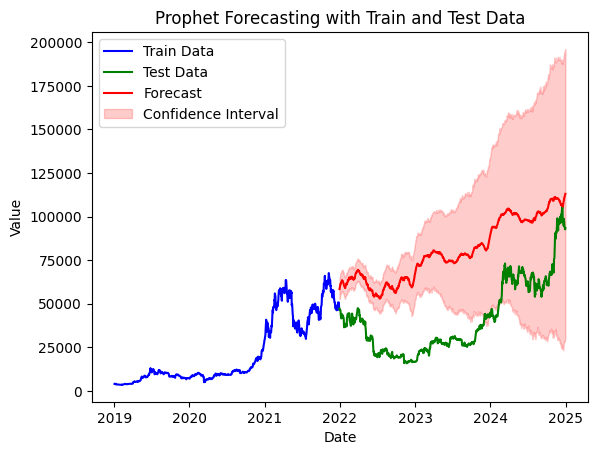

In [54]:
plt.clf()  # Clear the figure before each new plot
# Plot the results
# Clear the previous plot to avoid overlay
plt.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
plt.plot(data_test['ds'], data_test['y'], label='Test Data', color='green')
plt.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
plt.fill_between(forecasted_values['ds'], forecasted_values['yhat_lower'], forecasted_values['yhat_upper'], 
                color='red', alpha=0.2, label='Confidence Interval')

plt.title('Prophet Forecasting with Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
# Redraw the updated plot
# plt.draw()
# plt.pause(1)   # Pause for a short time to allow for the plot update (1 second in this case)
plt.show()

In [28]:
data_train_base = data_train
data_test_base = data_test

In [29]:
data_train = data_train_base
data_test = data_test_base

In [30]:
data_train.shape, data_test.shape

((755, 3), (755, 3))

In [31]:
import matplotlib
#matplotlib.use('TkAgg')  # or 'Qt5Agg'

In [32]:
def show_prediction(data_train, data_test, forecasted_values, ax, first_time):
    #plt.clf()  # Clear the figure before each new plot
    # Plot the results
    # Clear the previous plot to avoid overlay
    ax.plot(data_train['ds'], data_train['y'], label='Train Data', color='blue')
    ax.plot(data_test['ds'], data_test['y'], label='Test Data', color='green')
    ax.plot(forecasted_values['ds'], forecasted_values['yhat'], label='Forecast', color='red')
    ax.fill_between(forecasted_values['ds'], forecasted_values['yhat_lower'], forecasted_values['yhat_upper'], 
                    color='red', alpha=0.2, label='Confidence Interval')
    if first_time: 
        ax.set_title('Prophet Forecasting with Train and Test Data')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend()
    # Redraw the updated plot
    plt.draw()
    plt.pause(1)   # Pause for a short time to allow for the plot update (1 second in this case)
    


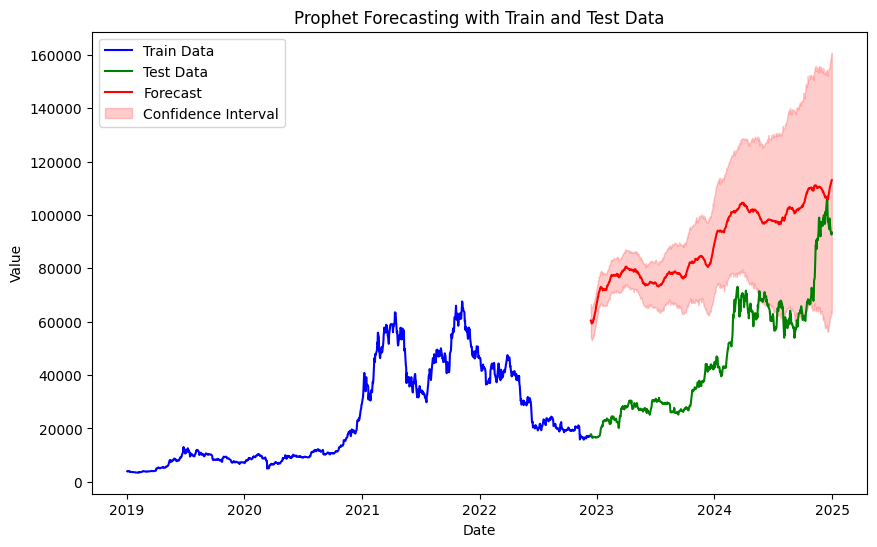

test shape (495, 3)


<Figure size 640x480 with 0 Axes>

test shape (475, 3)


<Figure size 640x480 with 0 Axes>

test shape (455, 3)


<Figure size 640x480 with 0 Axes>

test shape (435, 3)


<Figure size 640x480 with 0 Axes>

test shape (415, 3)


<Figure size 640x480 with 0 Axes>

test shape (395, 3)


<Figure size 640x480 with 0 Axes>

test shape (375, 3)


<Figure size 640x480 with 0 Axes>

test shape (355, 3)


<Figure size 640x480 with 0 Axes>

test shape (335, 3)


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [137]:
# Create the figure and axes outside the loop
fig, ax = plt.subplots(figsize=(10, 6))

# Enable interactive mode
#plt.ion()

show_prediction(data_train, data_test, forecasted_values, ax, True)
while len(data_test)>0:
    #plt.clf() 
    # data_train = pd.concat([data_train, data_test.iloc[[:20]]], axis = 0)
    data_train = pd.concat([data_train, data_test.iloc[:20]], axis = 0)

    data_test = data_test.iloc[20:]
    print(f"test shape {data_test.shape}")
    # Predict future values
    data_forcasting = prophet_model.predict(data_test[['ds', 'Close_S&P500']])

    # Extract the forecasted values and dates
    forecasted_values = data_forcasting[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    show_prediction(data_train, data_test, forecasted_values, ax, False)
    plt.pause(0.5) 

- Real Time BTC price

In [ ]:
import requests

def get_btc_price():
    url = 'https://api.kraken.com/0/public/Ticker?pair=XBTUSD'
    response = requests.get(url)
    data = response.json()
    return data['result']['XXBTZUSD']['c'][0]


for i in range(15):
    # Get real-time BTC price in USD
    btc_price = get_btc_price()
    print(f"Current Bitcoin price: ${btc_price}")
    time.sleep(2)

- Real Time news

In [162]:
import requests

def get_cryptocurrency_news():
    url = "https://cryptopanic.com/api/v1/posts/"
    params = {"auth_token": "7fc43f7898dc44c7b8a6841445915a92", "filter": "bitcoin"}
    response = requests.get(url, params=params)
    return response.json()

news_data = get_cryptocurrency_news()
print(news_data)

{'status': 'Incomplete', 'info': 'Token not found'}


In [163]:
import requests

def get_bitcoin_news(api_key):
    url = "https://newsapi.org/v2/everything"
    params = {
        'q': 'bitcoin',  # search query for bitcoin-related news
        'apiKey': api_key,  # your NewsAPI key
        'language': 'en',  # language filter
        'sortBy': 'publishedAt',  # sort by the most recent
        'pageSize': 5  # number of results per request
    }
    
    response = requests.get(url, params=params)
    news_data = response.json()
    
    if news_data['status'] == 'ok':
        return news_data['articles']
    else:
        return []

# Replace with your actual NewsAPI key
api_key = '7fc43f7898dc44c7b8a6841445915a92'
bitcoin_news = get_bitcoin_news(api_key)

# Print the titles of the fetched Bitcoin-related news
for article in bitcoin_news:
    print(f"Title: {article['title']}")
    print(f"Source: {article['source']['name']}")
    print(f"URL: {article['url']}")
    print(f"Published: {article['publishedAt']}")
    print()

Title: DOJ Says $12 Billion in Bitcoin Stolen in 2016 Hack Should Be Returned to Bitfinex
Source: Decrypt
URL: https://decrypt.co/301112/doj-12-billion-bitcoin-stolen-2016-hack-returned-bitfinex
Published: 2025-01-15T17:18:51Z

Title: Still Learning After All These Years
Source: Biztoc.com
URL: https://biztoc.com/x/38c324729617a638
Published: 2025-01-15T17:08:24Z

Title: U.S. Prosecutors Ask Court to Green-Light Return of 95,000 Stolen Bitcoin to Bitfinex
Source: Biztoc.com
URL: https://biztoc.com/x/ba3af6ed342da1d8
Published: 2025-01-15T17:08:04Z

Title: Robinhood Stock Soars As It Hits Best Financial And Best Crypto Lists
Source: Investor's Business Daily
URL: https://www.investors.com/news/robinhood-stock-best-financial-stock-crypto-stock-lists/
Published: 2025-01-15T17:03:27Z

Title: BlackRock’s quarterly revenue up 23 per cent to nearly US$5.7 billion
Source: Financial Post
URL: https://financialpost.com/investing/blackrocks-quarterly-revenue-up-to-us5-7-billion
Published: 2025-01

In [257]:
import requests

In [269]:
url = "https://newsapi.org/v2/everything"
api_key = '7fc43f7898dc44c7b8a6841445915a92'
start_date = "2024-01-01"
end_date = "2025-01-01"

params = {
    'q': 'bitcoin',  # search query for bitcoin-related news
    'apiKey': api_key,  # your NewsAPI key
    'language': 'en',  # language filter
    'sortBy': 'publishedAt',  # sort by the most recent
    'pageSize': 5,  # number of results per request
    'from': start_date,  # start date (YYYY-MM-DD)
    'to': end_date  # end date (YYYY-MM-DD)
}

response = requests.get(url, params=params)
news_data = response.json()

In [270]:
news_data

{'status': 'ok',
 'totalResults': 138,
 'articles': [{'source': {'id': 'financial-post', 'name': 'Financial Post'},
   'author': 'Bloomberg News',
   'title': 'Asia Kicks Off New Year After Ominous End to 2024: Markets Wrap',
   'description': 'Asian stocks were primed to begin the New Year on a sour note after an inauspicious end to an otherwise stellar 2024 for global equity investors.',
   'url': 'https://financialpost.com/pmn/business-pmn/asia-kicks-off-new-year-after-ominous-end-to-2024-markets-wrap',
   'urlToImage': 'https://smartcdn.gprod.postmedia.digital/financialpost/wp-content/uploads/2025/01/picking-up-sovereign-wealth-fund-investments-globally-rose--1.jpg',
   'publishedAt': '2025-01-01T23:27:23Z',
   'content': 'Asian stocks were primed to begin the New Year on a sour note after an inauspicious end to an otherwise stellar 2024 for global equity investors.\r\nAuthor of the article:\r\nun(m[l5jyrdyk(zqni7cl8y6_med… [+7459 chars]'},
  {'source': {'id': None, 'name': 'Ozbarg

In [266]:
news_data

{'status': 'error',
 'code': 'parameterInvalid',
 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-12-26, but you have requested 2024-01-01. You may need to upgrade to a paid plan.'}

In [264]:
import requests

# Query for Bitcoin-related news articles from GDELT
url = 'https://api.gdeltproject.org/api/v2/doc/doc?query=bitcoin&mode=ArtList'

response = requests.get(url)
news_data = response.json()

# Print the title and URL of the Bitcoin-related articles
for article in news_data['articles']:
    print(f"Title: {article['title']}")
    print(f"Published At: {article['published']}")
    print(f"URL: {article['url']}")
    print("-" * 80)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [164]:
news_data

{'status': 'Incomplete', 'info': 'Token not found'}

Current Bitcoin price: $98367.10000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98499.90000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98500.00000
Current Bitcoin price: $98499.90000
Current Bitcoin price: $98499.90000


KeyboardInterrupt: 

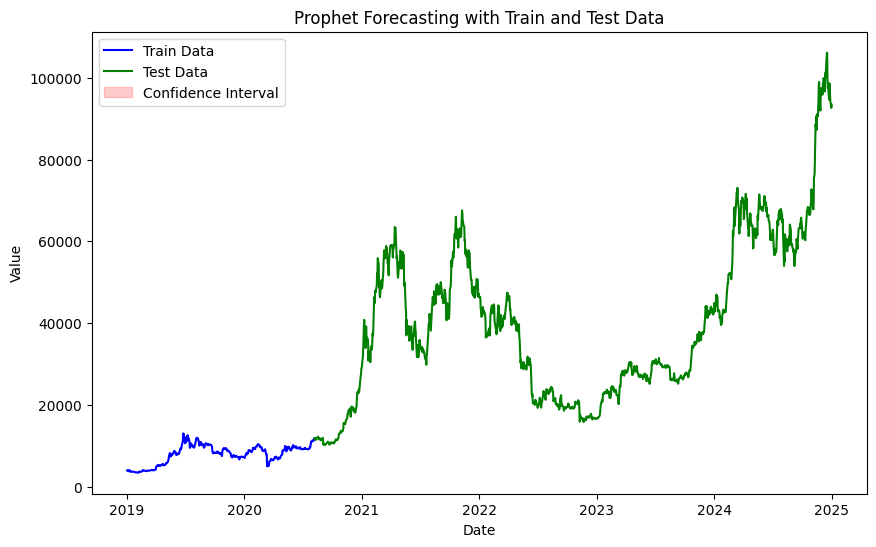

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [41]:
# Create the figure and axes outside the loop
fig, ax = plt.subplots(figsize=(10, 6))

# Enable interactive mode
#plt.ion()

show_prediction(data_train, data_test, fig, ax)
while len(data_test)>0:
    # data_train = pd.concat([data_train, data_test.iloc[[:20]]], axis = 0)
    data_train = pd.concat([data_train, data_test.iloc[:20]], axis = 0)

    data_test = data_test.iloc[20:]
    # Predict future values
    #data_forcasting = prophet_model.predict(data_test[['ds', 'Close_S&P500']])

    # Extract the forecasted values and dates
    #forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    show_prediction(data_train, data_test, fig, ax)
    plt.pause(0.5) 


# Disable interactive mode after the loop ends



In [38]:
# Print forecast data (optional)
print(forecast.tail())

            ds         trend    yhat_lower    yhat_upper  trend_lower  \
297 2024-12-24  14690.486893  37931.266591  72176.517537  -754.437673   
298 2024-12-26  14691.716972  37756.491709  72736.406007  -855.539465   
299 2024-12-27  14692.332012  36989.147627  72020.063765  -957.256296   
300 2024-12-30  14694.177130  36366.736891  71385.329271 -1057.743049   
301 2024-12-31  14694.792170  36182.756524  71346.405537 -1159.459881   

      trend_upper  Close_S&P500  Close_S&P500_lower  Close_S&P500_upper  \
297  31559.345155  40525.797900        40525.797900        40525.797900   
298  31644.226581  40482.907609        40482.907609        40482.907609   
299  31728.492968  39314.459146        39314.459146        39314.459146   
300  31813.989434  38195.901204        38195.901204        38195.901204   
301  31898.255821  37752.852529        37752.852529        37752.852529   

     additive_terms  ...       weekly  weekly_lower  weekly_upper  \
297    39891.984224  ...  2742.935344   2

In [1]:
from pycoingecko import CoinGeckoAPI
import time

In [2]:
# Initialize the CoinGecko client
cg = CoinGeckoAPI()

In [4]:
def get_real_time_btc_price():
    while True:
        # Fetch the current Bitcoin price in USD
        btc_data = cg.get_price(ids='bitcoin', vs_currencies='usd')
        btc_price = btc_data['bitcoin']['usd']
        print(f"BTC/USDT Price: {btc_price}")
        
        # Wait for 1 second before fetching the price again
        time.sleep(2)



In [5]:
# Start streaming real-time BTC price
get_real_time_btc_price()

BTC/USDT Price: 99622
BTC/USDT Price: 99622
BTC/USDT Price: 99622
BTC/USDT Price: 99622


KeyboardInterrupt: 